Problem 1
=========
   Part 1
   ------

The implicit difference equation is $\frac{a_j^{n+1} - a_j^n}{\Delta t} = -u \frac{a_j^{n+1} - a_{j-1}^{n+1}}{\Delta t}$

substitute in $a_j = A^n e^{-i k j \Delta x}$.

$\frac{A^{n+1} - A^n}{\Delta t} e^{ikj\Delta x} = -\frac{u}{\Delta x} A^{n+1} \left(e^{ikj\Delta x}- e^{ik(j-1)\Delta x}\right)$

Define $C = u \Delta x / \Delta t$, and cancel $e^{ikj\Delta x}$ from both sides.

$\frac{A^{n+1} - A^n}{A^{n+1}}  = - C \left(1 - e^{-ik\Delta x}\right)$

$1-\frac{A^n}{A^{n+1}}  = - C \left(1 - e^{-ik\Delta x}\right)$

$\frac{A^n}{A^{n+1}} = 1 + C \left(1 - e^{-ik\Delta x}\right)$

The criterion for *stability* is $|A^n/A^{n+1}| > 1$. (Note that this is the inverse of the criterion defined in the notes).

$e^{-ik\Delta x} = \cos(k \Delta x) - i \sin(k\Delta x)$

For notational simplicity, define $K = \cos(k \Delta x)$ and $S = \sin(k \Delta x)$.

$\frac{A^n}{A^{n+1}}  = 1 + C \left(1 - K +iS\right)$

 $\hspace{18pt} = 1 + C - CK + iCS$

$\left|\frac{A^n}{A^{n+1}}\right|^2 = (1 + C - CK)^2 + C^2S^2 > 1 \implies$ stable.

$\left|\frac{A^n}{A^{n+1}}\right|^2 = 1 + C - CK + C + C^2 - C^2 K -CK - C^2K + C^2K^2 + C^2S^2$

    since $K^2 + S^2$ = 1, 

$\left|\frac{A^n}{A^{n+1}}\right|^2 = 1 + 2C - 2CK - 2C^2K + 2C^2$

$\left|\frac{A^n}{A^{n+1}}\right|^2 = 1 + 2C\left[1 - K +C(1-K)\right]$

$\left|\frac{A^n}{A^{n+1}}\right|^2 = 1 + 2C(1+C)(1-K)$

when is this stable (because it exceeds unity)?

so long as the second term is not negative, the scheme is stable.

$1-K = 1 - \cos(k\Delta x) \geq 0$

Therefore, for any $C > 0$, this scheme is stable, which is to say for any  problem advancing forward in time with $\Delta t > 0$.

Part 2
------

Again starting with the difference equation for $j = 1, N$:

$\frac{a_j^{n+1} - a_j^n}{\Delta t} = -u \frac{a_j^{n+1} - a_{j-1}^{n+1}}{\Delta t}$

and defining $C = u \Delta x / \Delta t$ to get

$a_j^{n+1} - a_j^n = -C \left( a_j^{n+1} - a_{j-1}^{n+1}\right)$



rearranging,

$a_j^{n+1} + C a_j^{n+1} - C a_{j-1}^{n+1}  = a_j^n$

$(1+C) a_j^{n+1} - C a_{j-1}^{n+1}  = a_j^n$

The periodic boundary condition can be expressed as $a_{-1} = a_N$

This can be rewritten as the matrix equation $\bar{\bar{M}} \cdot \bar{a}^{n+1} = \bar{a}^n$, where the matrix 

$\bar{\bar{M}} = 
   \begin{bmatrix} 
     1+C & \dots & \dots & \dots & -C \\
     0   & \dots & -C & 1+C & \dots \\
     \dots & \dots & \ddots & \ddots & \dots \\
     0   & \dots & \dots & -C & 1+C 
   \end{bmatrix}$


The solution is then  $ \bar{a}^{n+1} = \bar{\bar{M}}^{-1} \cdot \bar{a}^n$.  This requires inverting the matrix $\bar{\bar{M}}$.

This is a sparse matrix, with most elements zero.  We could just use numpy.linalg.inv to invert the matrix, but that would be inefficient in both compute time and memory use.  Consider that a 1000 element grid would require a million matrix entries!

Instead, I will use scipy.sparse to define a sparse array, and scipy.sparse.linalg.spsolve to solve the equation.

Let's start by defining the matrix.

In [2]:
import scipy.sparse as sp
import scipy.sparse.linalg  as la
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline


def implicit_matrix(C,nx):
    """sets up the matrix required for an implicit solution of the periodic
    advection equation for Courant number C and grid size nx."""
    
    main_diag  = np.ones(nx)*(1.0 + C)
    other_diag = np.ones(nx-1)*(-C)
    
    #sp.diags takes the relevant diagonals, and their offsets from the main
    #diagonal.
    matrix = sp.diags([main_diag,other_diag],[0,-1])
    
    #to set the periodic boundary condition we need to choose a format 
    #that supports item assignment such as LIL (Google sparse matrix formats for more)
    matrix = matrix.tolil()
    matrix[0,nx-1] = -C
    
    return matrix

Let's try this out to make sure the matrix looks like we expect.

In [3]:
print(implicit_matrix(0.5, 5))

  (0, 0)	1.5
  (0, 4)	-0.5
  (1, 0)	-0.5
  (1, 1)	1.5
  (2, 1)	-0.5
  (2, 2)	1.5
  (3, 2)	-0.5
  (3, 3)	1.5
  (4, 3)	-0.5
  (4, 4)	1.5


We will use la.spsolve(matrix, RHS) to solve the implicit equation.  

Now we need to set up the grid and so forth, following the example shown in class for a finite difference solution.  I add the initial condition given in the problem set as "Gaussian"

In [4]:
class FDGrid(object):

    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords
        self.dx = (xmax - xmin)/(nx-1)
        self.x = xmin + (np.arange(nx+2*ng)-ng)*self.dx

        # storage for the solution
        self.a = np.zeros((nx+2*ng), dtype=np.float64)

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill a single ghostcell with periodic boundary conditions """
        self.a[self.ilo-1] = self.a[self.ihi-1]
        self.a[self.ihi+1] = self.a[self.ilo+1]

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))

    def init_cond(self, type="tophat"):

        if type == "tophat":
            self.a[np.logical_and(self.x >= 0.333, self.x <= 0.666)] = 1.0
        elif type == "sine":
            self.a[:] = np.sin(2.0*np.pi*self.x/(self.xmax-self.xmin))
        elif type == "Gaussian":
            self.a[:] = np.exp(-(self.x-0.5)**2.0/0.01)
        else:
            print("unknown type")

        self.ainit = self.a.copy()

In [5]:
def upwind_implicit(C, g):
    """separate out the actual solver so the evolve routine can be used 
             repeatedly
       the grid object g is passed in to the routine."""
    
    anew = g.scratch_array()

    #set up the implicit matrix (and convert to CSR for spsolve)
    matrix = implicit_matrix(C, g.nx).tocsr()
    
    #find and return the solution
    anew = la.spsolve(matrix, g.a)

    return anew

def evolve(g, C, u, tmax, solver):

    t = 0.0
    dt = C*g.dx/u


    g.a[:] = g.ainit[:]

    while t < tmax:

        if t + dt > tmax:
            dt = tmax - t
            C = u*dt/g.dx

        anew = solver(C, g)
        
        # store the updated solution
        g.a[:] = anew[:]

        t += dt



Part 3
------
We can try this out.  Let's define a somewhat general testing function using the code from the example

In [19]:
def run(C, nx, ng, np, init, solver, u = 1.0):
    
    #create the grid
    g = FDGrid(nx, ng)

    # time info for np periods around the grid
    tmax = np*(g.xmax - g.xmin)/u

    # initialize
    g.init_cond(type=init)

    # evolve using the input function 
    evolve(g, C, u, tmax, solver)
    
    return g


def test(C, nx, np, init, noplot = 0, ng = 0, solver = upwind_implicit):
    """C      = Courant number
       nx     = grid size
       np     = number of periods
       ng     = number of ghost zones (zero for default implicit method)
       init   = initial condition string
       solve = name of solution function"""
    
    g = run(C, nx, ng, np, init, solver)    

    if (noplot == 0):
        pl.plot(g.x[g.ilo:g.ihi+1], g.ainit[g.ilo:g.ihi+1], ls=":")
        pl.plot(g.x[g.ilo:g.ihi+1], g.a[g.ilo:g.ihi+1])

        pl.xlabel(r"$x$")
        pl.ylabel(r"$a$")

        pl.show()
    
    return g   #return the grid for further use

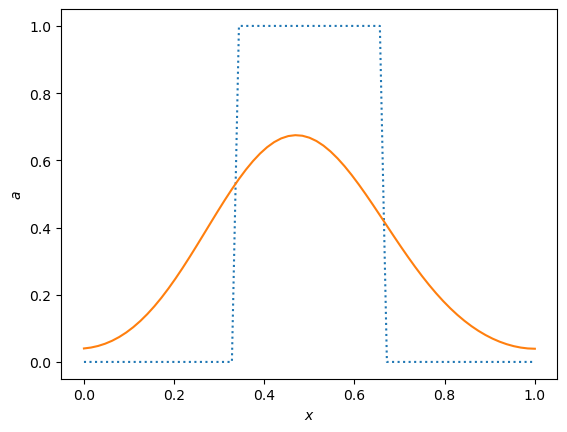

In [20]:
tophat = test(0.8, 65, 1.0, "tophat" )

It works... but it has both magnitude and phase errors much larger than the explicit method with the same Courant number that we saw in class.

Now let's compute the requested Gaussian, using the same function

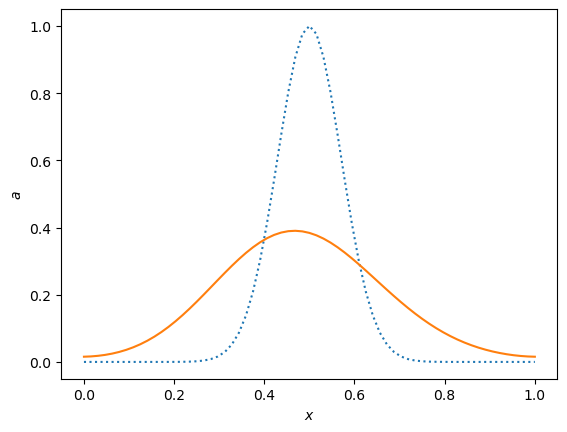

In [21]:
gauss = test(0.8, 65, 1.0, "Gaussian" )

And let's see how this depends on C and nx:

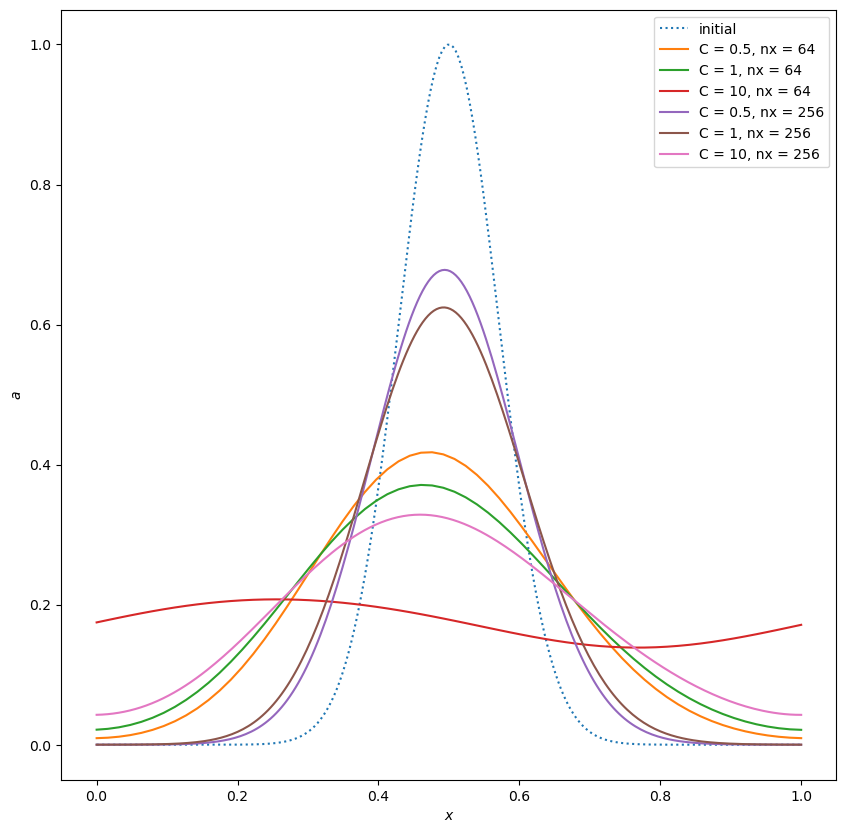

In [33]:
def solution_test(IC = "Gaussian", solver = upwind_implicit, ng = 0):
    Ctest  = [0.5, 1, 10]
    nxtest = np.array([64, 256]) + ng

    grids = []
    for nx in nxtest:
        for C in Ctest:
            g = test(C, nx, 1.0, IC, ng=ng, noplot=1, solver=solver)
            grids.append(g)

    pl.figure(figsize =(10,10))
    pl.plot(g.x[g.ilo:g.ihi+1], g.ainit[g.ilo:g.ihi+1], ls=":", label = "initial")
    
    i =0   #to keep track of labels (note the fill order of grids)
    for gr in grids:
        #print(i/3, np.int(i/3),i%3)  debug
        pl.plot(gr.x[gr.ilo:gr.ihi+1], gr.a[gr.ilo:gr.ihi+1],
                label = "C = "+str(Ctest[i%3])+", nx = "+str(nxtest[int(i/3)]) )
        i += 1
    
    pl.xlabel(r"$x$")
    pl.ylabel(r"$a$")
    pl.legend()

#run test    
solution_test()

Notice that $C = 10$ is fast, but very inaccurate!

Now, what about a top hat (for the graduates)?

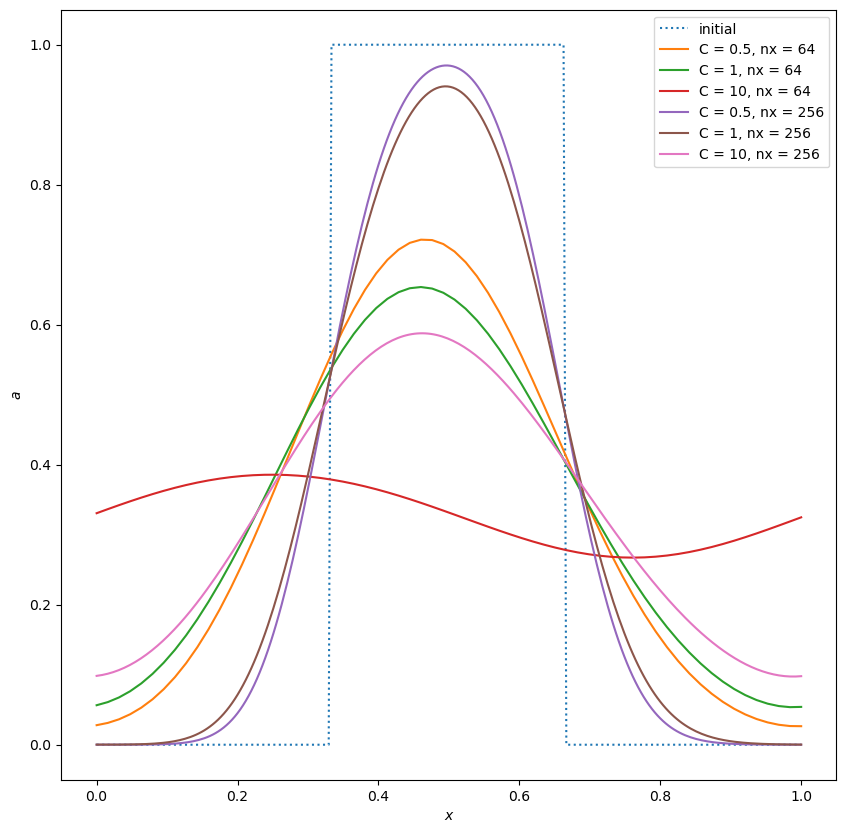

In [34]:
solution_test(IC = "tophat")

Problem 2
=========

We need to define a new solver function, but the rest of the machinery can be carried over. (I went back and generalized my `evolve` and `test` functions at this point to avoid repeating the main evolution loop)

In [35]:
def lax_wendroff(C, g):

    anew = g.scratch_array()

    g.fill_BCs()

    # loop over active zones: 
    for i in range(g.ilo, g.ihi+1):
        # Lax-Wendroff update
        anew[i] = g.a[i] - 0.5* C*(g.a[i+1] - g.a[i-1]) + \
                           0.5* C*C*(g.a[i+1] - 2.0*g.a[i] + g.a[i-1])
    
    return anew


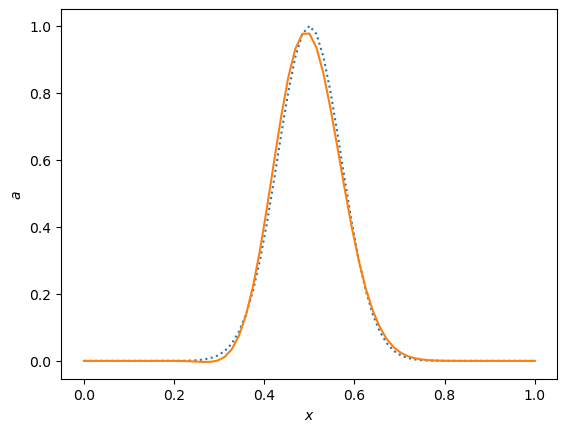

In [42]:
gauss = test(0.8, 65, 1.0, "Gaussian", ng = 1, solver = lax_wendroff)

There's a slight oscillation.   I wonder what the top hat looks like

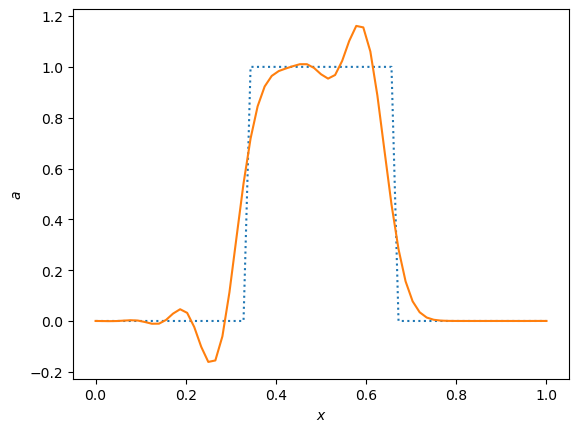

In [43]:
gauss = test(0.8, 65, 1.0, "tophat", ng = 1, solver = lax_wendroff )

In fact, higher-order methods don't reproduce discontinuities very well. 

Now let's measure the convergence, again following the example.

N,  err
17 0.1309517421069321
33 0.06073440688456308
65 0.01904370125160898
129 0.004979869309832284
257 0.0012535963312563898
1025 7.845205740684107e-05


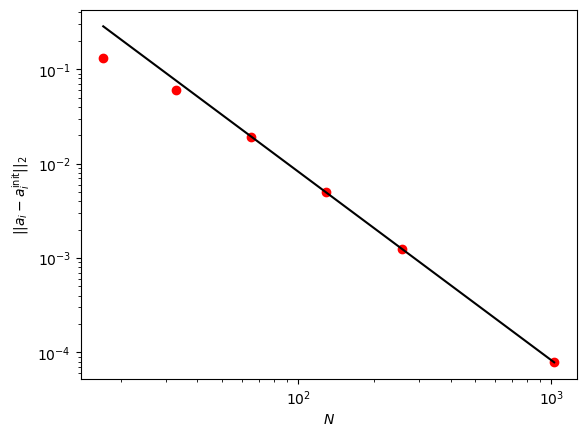

In [46]:
def convergence(init, solver = lax_wendroff, C = 0.8):
    """init is the initial condition string ("tophat", "sine", or "Gaussian")"""
      
    N = [17, 33, 65, 129, 257, 1025]
    err = []
    
    # define the speed, nunber of ghost zones, and number of periods 
    u    = 1.0
    ng   = 1
    nper = 1

    print ("N,  err")
    for nx in N:
        g = run(C, nx, ng, nper, init, solver, u = u)

        err.append(g.norm(g.a - g.ainit))
        print (nx, err[-1])
        
    N   = np.array(N, dtype=np.float64)
    err = np.array(err)
    
    pl.scatter(N, err, color="r")
    
    #must use index of slope = 2              \/
    pl.plot(N, err[len(N)-1]*(N[len(N)-1]/N)**2, color="k")
    
    ax = pl.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    pl.xlabel(r"$N$")
    pl.ylabel(r"$|| a_i - a^\mathrm{init}_i ||_2$")
    

convergence("Gaussian")

This is a second order method, so the slope of the comparison line must be $1/N^2$ rather than $1/N$

Let's also try a periodic initial condition: a sine wave

N,  err
17 0.04274874726495402
33 0.010554561541978353
65 0.0026071624289567925
129 0.0006472155693141587
257 0.0001612012784364921
1025 1.0046125773419796e-05


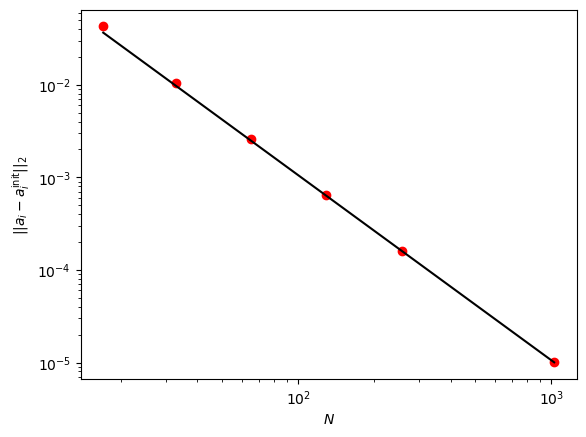

In [45]:
convergence("sine")

This periodic function shows even more exactly the expected 1/N<sup>2</sup> behavior.